# Analysis of Service Uptime

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import stats

path_libs = './packaging/src'
sys.path.insert(0, path_libs)
import calc_downtime 

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2


In [2]:
# list packages and their versions
import pkg_resources

packages = ['pandas', 'matplotlib', 'numpy', 'sys', 'scipy']

for m in pkg_resources.working_set:
    if m.project_name.lower() in packages:
        print(f"{m.project_name}=={m.version}")

scipy==1.3.1
pandas==0.25.1
numpy==1.17.2
matplotlib==3.1.1


## I. Exploratory analysis

In [3]:
# load data
filename = './data/logs.json'
df = pd.read_json(filename, lines=True, orient='records')

# convert time column into datetime object
df['time'] = pd.to_datetime(df['time'])

print(df.shape)
print(df['event'].unique())
df.head(3)

(177163, 6)
['createAccount' 'route' 'deleteAccount' 'heartbeat']


,event,accountId,accountName,time,serverId,workload
0,createAccount,3.0,Denny,2016-02-15,NaN,NaN
1,route,3.0,NaN,2016-02-15,2.0,NaN
2,createAccount,7.0,Hank,2016-02-15,NaN,NaN


In [4]:
# divde logs into different files by event
df_createAccount = df[df['event'] == 'createAccount']

df_deleteAccount = df[df['event'] == 'deleteAccount']

df_route = df[df['event'] == 'route']
df_route = df_route.set_index('time').sort_index()

df_heartbeat_raw = df[df['event'] == 'heartbeat']
df_heartbeat_raw = df_heartbeat_raw.set_index ('time')

#### Dataframes - create account and delete account

In [5]:
# find all customers
print(df_createAccount.shape)
df_createAccount

(13, 6)


,event,accountId,accountName,time,serverId,workload
0,createAccount,3.0,Denny,2016-02-15,NaN,NaN
2,createAccount,7.0,Hank,2016-02-15,NaN,NaN
102,createAccount,2.0,Carol,2016-02-16,NaN,NaN
104,createAccount,12.0,Kate,2016-02-16,NaN,NaN
294,createAccount,4.0,Esther,2016-02-17,NaN,NaN
591,createAccount,6.0,Gabby,2016-02-18,NaN,NaN
1187,createAccount,1.0,Bob,2016-02-20,NaN,NaN
1189,createAccount,8.0,Issac,2016-02-20,NaN,NaN
2799,createAccount,9.0,Jack,2016-02-24,NaN,NaN
3215,createAccount,0.0,Adam,2016-02-25,NaN,NaN


In [6]:
# find deleteAccount info
df_deleteAccount

,event,accountId,accountName,time,serverId,workload
4177,deleteAccount,12.0,NaN,2016-02-27,NaN,NaN
5537,deleteAccount,4.0,NaN,2016-03-01,NaN,NaN
5538,deleteAccount,6.0,NaN,2016-03-01,NaN,NaN
5938,deleteAccount,9.0,NaN,2016-03-02,NaN,NaN
7169,deleteAccount,0.0,NaN,2016-03-06,NaN,NaN
7172,deleteAccount,7.0,NaN,2016-03-06,NaN,NaN
8983,deleteAccount,1.0,NaN,2016-03-11,NaN,NaN


Check if any account is closed and reopen with the same accountId

In [7]:
df_createAccount.groupby(["accountId"]).size()

accountId
0.0     1
1.0     1
2.0     1
3.0     1
4.0     1
5.0     1
6.0     1
7.0     1
8.0     1
9.0     1
12.0    1
15.0    1
16.0    1
dtype: int64

In [8]:
df_deleteAccount.groupby(["accountId"]).size()

accountId
0.0     1
1.0     1
4.0     1
6.0     1
7.0     1
9.0     1
12.0    1
dtype: int64

Observation: \
It looks that no account has been closed and reopened with the same accountId within this time period.

In [9]:
# construct a table for account creation/deletion info

df_createAcc = df_createAccount[['accountId', 'accountName', 'time']].rename(columns = {'time':'startTime'})
df_createAcc = df_createAcc.set_index('accountId')

df_deleteAcc = df_deleteAccount[['accountId', 'time']].rename(columns = {'time':'endTime'})
df_deleteAcc = df_deleteAcc.set_index('accountId')

df_acc = pd.concat([df_createAcc, df_deleteAcc], axis=1, sort=False)
 
# fill NaT in the endTime column
df_acc = df_acc.fillna(df['time'].max())

# add a column of deltaTime
df_acc['deltaTime'] = df_acc['endTime'] - df_acc['startTime']
df_acc['deltaTime_min'] = df_acc['deltaTime'].apply(lambda x: x.days * 24 * 60 + x.seconds / 60 + 1)

df_acc

,accountName,startTime,endTime,deltaTime,deltaTime_min
accountId,,,,,
0.0,Adam,2016-02-25,2016-03-06 00:00:00,10 days 00:00:00,14401.0
1.0,Bob,2016-02-20,2016-03-11 00:00:00,20 days 00:00:00,28801.0
2.0,Carol,2016-02-16,2016-03-14 23:59:00,27 days 23:59:00,40320.0
3.0,Denny,2016-02-15,2016-03-14 23:59:00,28 days 23:59:00,41760.0
4.0,Esther,2016-02-17,2016-03-01 00:00:00,13 days 00:00:00,18721.0
5.0,Frank,2016-03-06,2016-03-14 23:59:00,8 days 23:59:00,12960.0
6.0,Gabby,2016-02-18,2016-03-01 00:00:00,12 days 00:00:00,17281.0
7.0,Hank,2016-02-15,2016-03-06 00:00:00,20 days 00:00:00,28801.0
8.0,Issac,2016-02-20,2016-03-14 23:59:00,23 days 23:59:00,34560.0


Note the startTime and endTime may not be always at exact minute.

As startTime and endTime will be used to create time index for the following minute-based analysis, let's create two new columns to set time to be the previous last exact minute.

In [10]:
df_acc['startTime_app'] = (df_acc['startTime'] - pd.Timedelta('29s')).dt.round('min')
df_acc['endTime_app'] = (df_acc['endTime'] - pd.Timedelta('29s')).dt.round('min')
df_acc

,accountName,startTime,endTime,deltaTime,deltaTime_min,startTime_app,endTime_app
accountId,,,,,,,
0.0,Adam,2016-02-25,2016-03-06 00:00:00,10 days 00:00:00,14401.0,2016-02-25,2016-03-06 00:00:00
1.0,Bob,2016-02-20,2016-03-11 00:00:00,20 days 00:00:00,28801.0,2016-02-20,2016-03-11 00:00:00
2.0,Carol,2016-02-16,2016-03-14 23:59:00,27 days 23:59:00,40320.0,2016-02-16,2016-03-14 23:59:00
3.0,Denny,2016-02-15,2016-03-14 23:59:00,28 days 23:59:00,41760.0,2016-02-15,2016-03-14 23:59:00
4.0,Esther,2016-02-17,2016-03-01 00:00:00,13 days 00:00:00,18721.0,2016-02-17,2016-03-01 00:00:00
5.0,Frank,2016-03-06,2016-03-14 23:59:00,8 days 23:59:00,12960.0,2016-03-06,2016-03-14 23:59:00
6.0,Gabby,2016-02-18,2016-03-01 00:00:00,12 days 00:00:00,17281.0,2016-02-18,2016-03-01 00:00:00
7.0,Hank,2016-02-15,2016-03-06 00:00:00,20 days 00:00:00,28801.0,2016-02-15,2016-03-06 00:00:00
8.0,Issac,2016-02-20,2016-03-14 23:59:00,23 days 23:59:00,34560.0,2016-02-20,2016-03-14 23:59:00


In [11]:
# For this example log, check if there are any startTime and endTime that are not at exact minute. 

print(np.unique(df_acc['endTime_app'] == df_acc['endTime'], return_counts=True))
print(np.unique(df_acc['startTime_app'] == df_acc['startTime'], return_counts=True))

# It turned out the startTime and endTime in this log file all happen at exact minute.

(array([ True]), array([13]))
(array([ True]), array([13]))


#### Dataframe - Route  

As heartbeat is recorded every minute and we assume that the workload during the following minute is the same as the workload logged in the heartbeat, it is reasonable to set the routing time at non-exact minute to be at the previous last exact minute. 

In [12]:
# Question: in this current route log, do routing all happen at the exact minute?
test = df_route.reset_index()
test[['ymd', 'hms']] = test.time.astype(str).str.split(' ', expand=True)
test[['h', 'm', 's']] =test['hms'].astype(str).str.split(':', expand=True)
test.head(2)
test.s.describe()

# Answer: yes, all routing happen at the exact minute in this current route log.
# Note: this is not always true. Routing can happen at non-exact minute.

count     10146
unique        1
top          00
freq      10146
Name: s, dtype: object

In [13]:
# Handling of routing time:

# find the accurate routing time, the exact minute right before and after routing
# if routing happens at the exact minute, then
#    the exact minute right before routing = reported time - 1 
#    the exact minute right after routing = reported time

df_route.loc[:, 'time_accu'] = df_route.index

cond1 = df_route.loc[:, 'time_accu'].dt.second == 0
cond2 = df_route.loc[:, 'time_accu'].dt.second > 0

df_route_cond1 = df_route[cond1]
df_route_cond2 = df_route[cond2]

df_route_cond1.loc[:, 'time_prev'] = df_route_cond1.loc[:, 'time_accu'] - pd.Timedelta('60s')
df_route_cond1.loc[:, 'time_post'] = df_route_cond1.loc[:, 'time_accu']

df_route_cond2.loc[:, 'time_prev'] = (df_route_cond2.index - pd.Timedelta('29s')).round('min')
df_route_cond2.loc[:, 'time_post'] = df_route_cond2.loc[:, 'time_prev'] + pd.Timedelta('60s')

print(df_route_cond1.shape)
print(df_route_cond2.shape)

# combine, sort index
df_route_conds = pd.concat([df_route_cond1, df_route_cond2], axis=0).sort_index()


# use the last exact minute as time index, to match with heartbeat recording interval
df_route_conds.index = (df_route_conds.index - pd.Timedelta('29s')).round('min')
print(df_route_conds.shape)

(10146, 8)
(0, 8)
(10146, 8)


In [31]:
# for each user, find the "routing-from" and "routing-to" serverIds at each routing event
user_list = df_acc.index.values

df_route_users = pd.DataFrame()

for user in user_list:
    df_user = df_route_conds[df_route_conds['accountId'] == user]
    df_user.loc[:, 'serverId_from'] = df_user.loc[:, 'serverId'].shift(periods=1, axis=0)
    df_user.loc[:, 'serverId_to'] = df_user.loc[:, 'serverId']
    
    df_route_users = pd.concat([df_route_users, df_user], axis=0)
    
df_route_users.head(2)


,event,accountId,accountName,serverId,workload,time_accu,time_prev,time_post,serverId_from,serverId_to
2016-02-25 00:00:00,route,0.0,NaN,1.0,NaN,2016-02-25 00:00:00,2016-02-24 23:59:00,2016-02-25 00:00:00,NaN,1.0
2016-02-25 01:00:00,route,0.0,NaN,2.0,NaN,2016-02-25 01:00:00,2016-02-25 00:59:00,2016-02-25 01:00:00,1.0,2.0


#### Dataframe - server heartbeat 

Handling of NA data: \
According to the instruction -
If the workload is above 1.0 or the server node stops logging heartbeats, all websites assigned to this node are considered as non-operational, i.e., service down. Given this, let's fill in the NA data with workload higher than 1 (i.e. 1.5 is chosen here).

In [15]:
serverId_list = np.unique(df_heartbeat_raw.serverId.values)

df_heartbeat = pd.DataFrame()

for server in serverId_list:
    df_heartbeat_s = df_heartbeat_raw[df_heartbeat_raw['serverId'] == server]
    
    timerange_s = pd.date_range(start=df_heartbeat_s.index.min(), end=df_heartbeat_s.index.max(), freq='min')
    df_heartbeat_s = df_heartbeat_s.reindex(timerange_s)
    
    # fillna of serverId
    df_heartbeat_s[['serverId']] = df_heartbeat_s[['serverId']].fillna(value=server)
    
    # fillna of workload
    df_heartbeat_s[['workload']] = df_heartbeat_s[['workload']].fillna(value=1.5)

    df_heartbeat = pd.concat([df_heartbeat, df_heartbeat_s], axis=0)
    
df_heartbeat = df_heartbeat.sort_index()

Text(0, 0.5, 'workload')

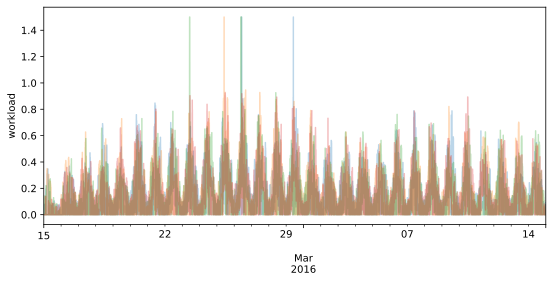

In [16]:
# heartbeat of servers over time
fig, ax = plt.subplots()
df_heartbeat.groupby('serverId').plot(y='workload', ax=ax, legend=False, alpha=0.3, figsize=[9,4])
plt.ylabel('workload')

(-0.1, 0.6)

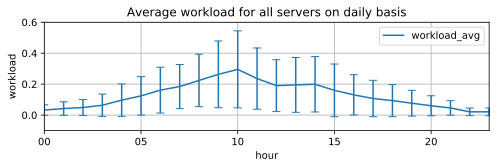

In [17]:
# check 24h distrubution of workload
test2 = df_heartbeat
test2['time'] = df_heartbeat.index
test2 = test2.reset_index()
test2[['ymd', 'hms']] = test2.time.astype(str).str.split(' ', expand=True)
test2[['h', 'm', 's']] =test2['hms'].astype(str).str.split(':', expand=True)

fig, ax = plt.subplots(1, 1)

std_bygroup = test2.groupby('h').std()['workload']

test2.groupby('h').mean().plot(y='workload', ax=ax, yerr = std_bygroup,figsize=[8,2],\
                               label='workload_avg', capsize = 4)

plt.grid()
plt.title('Average workload for all servers on daily basis')
plt.xlabel('hour')
plt.ylabel('workload')
plt.xlim([0, 23])
plt.ylim([-0.1, 0.6])


Text(0, 0.5, 'workload')

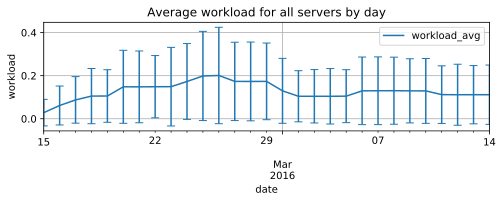

In [18]:
test3 = test2.set_index('time')

fig, ax = plt.subplots(1, 1)

std_bygroup = test3.resample('D').std()['workload']

test3.resample('D').mean().plot(y='workload', ax=ax, yerr = std_bygroup,figsize=[8,2],\
                               label='workload_avg', capsize = 4)
plt.grid()
plt.title('Average workload for all servers by day')
plt.xlabel('date')
plt.ylabel('workload')
# plt.ylim([0, 0.3])

In [19]:
# check the uptime of servers from the heartbeat dataframe

serverId_list = np.unique(df_heartbeat.serverId.values)
for server in serverId_list:
    df_hb_s = df_heartbeat[df_heartbeat['serverId'] == server]
    time_range_s = df_hb_s.index.max() - df_hb_s.index.min() + pd.Timedelta(minutes=1)
    time_range_s_min = time_range_s.days * 24 * 60 + time_range_s.seconds / 60
    
    uptime_s = df_hb_s[df_hb_s['workload'] <= 1].shape[0]
    downtime_s = time_range_s_min - uptime_s
    
    print('serverId: ', server)
    print('    time range:      ', time_range_s)
    # print('    time range(min): ', time_range_s_min, 'min')
    print('    uptime:          ', uptime_s, 'min')
    print('    downtime:        ', downtime_s, 'min')
    print()


serverId:  0.0
    time range:       29 days 00:00:00
    uptime:           41745 min
    downtime:         15.0 min

serverId:  1.0
    time range:       29 days 00:00:00
    uptime:           41759 min
    downtime:         1.0 min

serverId:  2.0
    time range:       29 days 00:00:00
    uptime:           41716 min
    downtime:         44.0 min

serverId:  3.0
    time range:       29 days 00:00:00
    uptime:           41760 min
    downtime:         0.0 min



## II. Sanity check - Issac's downtime

In [20]:
# Sanity check - Issac's accountId is 8.0
userId = 8.0

df_route_user = df_route_users[df_route_users['accountId'] == userId]

In [21]:
# ---- Calculate approximate downtime ----

# process routing data
df_route_user_sel_s = df_route_user[['event', 'accountId', 'serverId']]

# process heartbeat data
df_heartbeat_sel_s = df_heartbeat[['serverId', 'workload']].\
                   rename(columns={'serverId':'serverId_hb', 'workload':'workload_hb'})

# timerange for userID
timerange = pd.date_range(start=df_acc.loc[userId, 'startTime_app'], 
            end=df_acc.loc[userId, 'endTime_app'], freq='min')

# set timerange for userID to be index of the route_userID dataframe
df_route_user_exp = df_route_user_sel_s.reindex(timerange, method='ffill')

# combine the expanded route_userID with heartbeat 
df_comb = pd.concat([df_route_user_exp, df_heartbeat_sel_s], axis=1, sort=False)

# extract userID data - all time, route, server, workload
df_user = df_comb.loc[ (df_comb['serverId'] == df_comb['serverId_hb'])]

# calculate approximate downtime
uptime = df_user[df_user['workload_hb'] <=1].shape[0]
time_requested = df_acc.loc[userId, 'deltaTime_min'] 
downtime_app_minutes = time_requested - uptime


In [22]:
# ---- Examine corner case: routing at non-exact minute ----

# process router data
df_route_user_sel = df_route_user[['event', 'accountId', 'time_accu', 'time_prev',\
                                   'time_post', 'serverId_from', 'serverId_to']]

# process hearbeat data
df_heartbeat_sel = df_heartbeat[['serverId', 'workload']]

df_heartbeat_sel.loc[:, 'time_prev'] = df_heartbeat_sel.index
df_heartbeat_sel.loc[:, 'time_post'] = df_heartbeat_sel.index
df_heartbeat_sel.loc[:, 'serverId_from'] = df_heartbeat_sel.loc[:, 'serverId']
df_heartbeat_sel.loc[:, 'serverId_to'] = df_heartbeat_sel.loc[:, 'serverId']

df_heartbeat_sel = df_heartbeat_sel[['workload', 'time_prev', 'time_post', 'serverId_from', 'serverId_to']]


# add workload for serverId_from at time_prev
df_route_user_prev = pd.merge(df_route_user_sel, df_heartbeat_sel, how='left',\
                                 on=['time_prev', 'serverId_from']) 

cols_sel = ['event', 'accountId', 'time_accu', 'time_prev', 'serverId_from', 'workload', \
            'time_post_x', 'serverId_to_x']

cols_rename = {'workload':'workload_from', 'time_post_x':'time_post', 'serverId_to_x':'serverId_to'}

df_route_user_prev = df_route_user_prev[cols_sel].rename(columns=cols_rename)

# add workload for serverId_to at time_to
df_route_user_prevpost = pd.merge(df_route_user_prev, df_heartbeat_sel, how='left',\
                                  on=['time_post', 'serverId_to'])

cols_sel2 = ['event', 'accountId', 'time_accu', 'time_prev_x', 'serverId_from_x', 'workload_from', \
            'time_post', 'serverId_to', 'workload']

cols_rename2 = {'workload':'workload_to', 'time_prev_x':'time_prev', 'serverId_from_x':'serverId_from'}

df_route_user_prevpost = df_route_user_prevpost[cols_sel2].rename(columns=cols_rename2)

# find the cases when time_accu is non-exact minute
df_route_user_cc = df_route_user_prevpost[df_route_user_prevpost['time_accu'].dt.second != 0]


# if serverId_from is na, ignore data
df_route_user_cc = df_route_user_cc[df_route_user_cc['serverId_from'].notna()] 

# Routing server_from is up and server_to is down -> add the seconds before routing to total server uptime.
# Routing server_from is down server_to is up -> deduct the seconds after routing from total server uptime.
condition_1 = (df_route_user_cc['workload_from'] <= 1) | (df_route_user_cc['workload_to'] > 1)
condition_2 = (df_route_user_cc['workload_from'] > 1) | (df_route_user_cc['workload_to'] <= 1)

uptime_add_seconds = df_route_user_cc[condition_1].time_accu.dt.second
uptime_deduct_seconds = 60 - df_route_user_cc[condition_2].time_accu.dt.second
uptime_comp_seconds = sum(uptime_add_seconds) - sum(uptime_deduct_seconds)

downtime = downtime_app_minutes - (uptime_comp_seconds / 60.0)

print('The accurate downtime for accountId', userId, 'is', '%.3f' % downtime, 'min.')   

The accurate downtime for accountId 8.0 is 34.000 min.


## III. Calculate all user's downtime

In [23]:
obj = calc_downtime.calcDowntime(df_route_users, df_heartbeat, df_acc)
df_acc2 = obj.calc_downtime_percentage()

processing accountId  0.0
processing accountId  1.0
processing accountId  2.0
processing accountId  3.0
processing accountId  4.0
processing accountId  5.0
processing accountId  6.0
processing accountId  7.0
processing accountId  8.0
processing accountId  9.0
processing accountId  12.0
processing accountId  15.0
processing accountId  16.0


In [24]:
# The customers who experienced more than 0.1% downtime are:
df_acc3 = df_acc2[df_acc2['downtime (%)'] > 0.1].loc[:, ['accountName', 'deltaTime', \
                                                         'downtime_min', 'downtime (%)']]
df_acc3 = df_acc3.rename(columns = {'deltaTime':'accountLifetime', 'downtime_min':'downtime (minute)'})
df_acc3

,accountName,accountLifetime,downtime (minute),downtime (%)
accountId,,,,
4.0,Esther,13 days,44.0,0.24
6.0,Gabby,12 days,56.0,0.32
7.0,Hank,20 days,38.0,0.13
9.0,Jack,7 days,38.0,0.38
12.0,Kate,11 days,31.0,0.20


## IV. Statistical hypothesis test

<B> First, process route data and hearbeat data.</B>

In [25]:
# get useful route data
route = df_route_users[['event', 'accountId', 'time_accu', 'time_prev',\
                                  'serverId_from', 'serverId_to']]

cond_eff = (route['serverId_from'] != route['serverId_to']) & (route['serverId_from'].notna())
route = route[cond_eff]

# get useful heartbeat data
hb = df_heartbeat_sel[['workload', 'time_prev', 'serverId_from', 'serverId_to']]


# get workload for serverId_from at time_prev
route_hb_sFrm = pd.merge(route, hb, how='left', on=['time_prev', 'serverId_from'])
cols_keep = ['event', 'accountId', 'time_accu', 'time_prev', 'serverId_from', 'workload', 'serverId_to_x']
cols_rename = {'workload':'workload_sFrm', 'serverId_to_x':'serverId_to'}
route_hb_sFrm = route_hb_sFrm[cols_keep].rename(columns=cols_rename)

# get workload for serverId_to at time_prev
route_hb_sFrm_sTo = pd.merge(route_hb_sFrm, hb, how='left', on=['time_prev', 'serverId_to'])
cols_keep2 = ['event', 'accountId', 'time_accu', 'time_prev', 'serverId_from_x', \
              'workload_sFrm', 'serverId_to', 'workload']
cols_rename2 = {'workload':'workload_sTo', 'serverId_from_x':'serverId_from'}
route_hb_sFrm_sTo = route_hb_sFrm_sTo[cols_keep2].rename(columns=cols_rename2)


print(route_hb_sFrm_sTo.shape)
route_hb_sFrm_sTo.head(2)

(7593, 8)


,event,accountId,time_accu,time_prev,serverId_from,workload_sFrm,serverId_to,workload_sTo
0,route,0.0,2016-02-25 01:00:00,2016-02-25 00:59:00,1.0,0.079819,2.0,0.017365
1,route,0.0,2016-02-25 02:00:00,2016-02-25 01:59:00,2.0,0.045365,1.0,0.011837


<B> Second, find the "to" serverId and "from" serverId, and their workload at i minutes before routing. </B>

Sanity check: \
Check the time interval between routing for each server. Find out the minimum time interval.

In [26]:
userId_list = df_acc2.index.values

df_all_users = pd.DataFrame()

for user_i in userId_list:
    print("accountId: ", user_i)
    
    route_hb_user = route_hb_sFrm_sTo[route_hb_sFrm_sTo['accountId'] == user_i]
    route_hb_user = route_hb_user.set_index(np.arange(route_hb_user.shape[0]))
    
    route_hb_user.loc[:, 'dt_route'] = route_hb_user.loc[:, 'time_prev'].diff()
    dt_routing_minimum = route_hb_user['dt_route'].min()
    dt_routing_minimum_min = dt_routing_minimum.days * 24 * 60 + dt_routing_minimum.seconds / 60
    print("    Min routing time interval: ", dt_routing_minimum_min, "minutes.")


accountId:  0.0
    Min routing time interval:  1.0 minutes.
accountId:  1.0
    Min routing time interval:  1.0 minutes.
accountId:  2.0
    Min routing time interval:  1.0 minutes.
accountId:  3.0
    Min routing time interval:  1.0 minutes.
accountId:  4.0
    Min routing time interval:  1.0 minutes.
accountId:  5.0
    Min routing time interval:  1.0 minutes.
accountId:  6.0
    Min routing time interval:  1.0 minutes.
accountId:  7.0
    Min routing time interval:  1.0 minutes.
accountId:  8.0
    Min routing time interval:  1.0 minutes.
accountId:  9.0
    Min routing time interval:  1.0 minutes.
accountId:  12.0
    Min routing time interval:  1.0 minutes.
accountId:  15.0
    Min routing time interval:  1.0 minutes.
accountId:  16.0
    Min routing time interval:  1.0 minutes.


Observation:\
The minimum routing interval is 1 minute. Therefore, when retrieving the "from" serverId, we should only go back by 1 minute, to avoid jumping back too much to study the irrelevant server.

### <B> Third, form the hypothesis. </B>

If the manager's routing strategy is not dependent on workload, then it is reasonable to assume that the workload difference between routing "from" and routing "to" servers (at 1 minute before routing) should form a normal distribution with mean of 0.

Note that the underlying assumption for the use of t-Test is that the routing events are independent and identically distributed.

In [27]:
route_hb_sFrm_sTo.head(2)

,event,accountId,time_accu,time_prev,serverId_from,workload_sFrm,serverId_to,workload_sTo
0,route,0.0,2016-02-25 01:00:00,2016-02-25 00:59:00,1.0,0.079819,2.0,0.017365
1,route,0.0,2016-02-25 02:00:00,2016-02-25 01:59:00,2.0,0.045365,1.0,0.011837


count    7593.000000
mean        0.072136
std         0.211885
min        -0.860093
25%        -0.031149
50%         0.045789
75%         0.175269
max         1.500000
dtype: float64

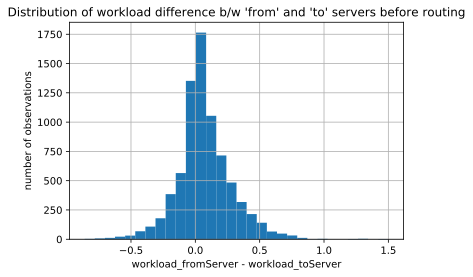

In [28]:
# At 1 minute prior to routing, what's the difference b/w the workload of serverId_to and serverId_from
# expect: "from" should be higher than "to"

diff_workload = route_hb_sFrm_sTo['workload_sFrm'] - route_hb_sFrm_sTo['workload_sTo']

diff_workload.hist(bins=30)
plt.title("Distribution of workload difference b/w 'from' and 'to' servers before routing")
plt.xlabel("workload_fromServer - workload_toServer")
plt.ylabel("number of observations")
diff_workload.describe()

#### One-Sample t-Test

H_0: routing does not depend on workload, mean(diff_workload) = 0.\
H_a: routing depends on workload, mean(diff_workload) != 0.

Choose two-tailed one sample T-Test. 

Significant level: alpha = 0.05\
Degrees of freedom: degree_of_freedom

The test statistic is a t statistic (t) defined by:\
    t = (x - M) / [ s /sqrt(n) ]

The P-value is the probability of observing a sample statistic as extreme as the test statistic.

If P-value < alpha: reject H_0, suggest H_a;\
Otherwise, fail to reject H_0. 


In [29]:
degree_of_freedom = diff_workload.count() - 1
diff_workload_arr = diff_workload.values

print(degree_of_freedom)

7592


In [30]:
alpha = 0.005

T_score, p_value = stats.ttest_1samp(diff_workload_arr, 0)

print("T-score is: ", T_score)
print("p-value is: ", p_value)

print("p_value < alpha:", p_value < alpha)


T-score is:  29.6661500384867
p-value is:  4.3133127640141284e-183
p_value < alpha: True


### Conclusion: 

The result of t-Test is P-value < alpha. \
This entails that we should reject null hypothesis.\
Therefore, the statistical test suggests the alternative hypothesis - routing depends on workload.


<u> Reference: </u>\
https://stattrek.com/statistics/dictionary.aspx?definition=one-sample%20t-test \
https://www.statisticshowto.datasciencecentral.com/one-sample-z-test/